In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torchvision

import sys
sys.path.append('../')

from dataloading.nvidia import NvidiaDataset, NvidiaTrainDataset, NvidiaValidationDataset
from metrics import calculate_closed_loop_metrics, calculate_lateral_errors, calculate_interventions

%load_ext autoreload 
%autoreload 2

In [13]:
def calculate_metrics(driving_ds, expert_ds):
    metrics_df = pd.DataFrame(columns=["model", "traj_mae", "traj_rmse", "traj_max", "traj_failure_rate", 
                                       "interventions", "whiteness", "expert_whiteness"])

    for name, ds in driving_ds.items():
        print(f"Calculating metrics for {name}")
        metrics = calculate_closed_loop_metrics(ds.frames, expert_ds.frames, ds.vehicle_cmd_frames)
        metrics['model'] = name
        metrics_df = metrics_df.append(metrics, ignore_index=True)
        
    return metrics_df

In [14]:
def draw_error_plot_ax(ax, model_ds, expert_ds, title=None):
    lat_errors = calculate_lateral_errors(model_ds.frames[:-1000], expert_ds.frames, only_autonomous=True)
    positions_df = model_ds.frames[:-1000]
    
    autonomous_df = positions_df[positions_df.autonomous].reset_index(drop=True)
    ax.scatter(autonomous_df["position_x"], autonomous_df["position_y"],
               s=5,
               c=lat_errors, cmap=plt.cm.coolwarm)
    
    manual_df = positions_df[positions_df.autonomous == False].reset_index(drop=True)
    ax.scatter(manual_df["position_x"], manual_df["position_y"],
                s=5,
                c="#2BFA00")
    
    positions_df['autonomous_next'] = positions_df.shift(-1)['autonomous']
    interventions_df = positions_df[positions_df.autonomous & (positions_df.autonomous_next == False)]
    ax.scatter(interventions_df["position_x"], interventions_df["position_y"],
                s=150,
               marker='x',
                c="red")
    
    if title:
        ax.set_title(title)

In [15]:
def draw_error_plot(model_ds, expert_ds, title=None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    draw_error_plot_ax(ax, model_ds, expert_ds, title)

In [18]:
root_path = Path("/data/Bolt/end-to-end/drives-ebm-paper/")
expert_ds = NvidiaDataset([root_path / '2021-10-26-10-49-06_e2e_rec_ss20_elva_eval_chunk'])
expert_back_ds = NvidiaDataset([root_path / '2021-10-26-11-08-59_e2e_rec_ss20_elva_back_eval_chunk'])

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2021-10-26-10-49-06_e2e_rec_ss20_elva_eval_chunk: length=13858, filtered=2
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2021-10-26-11-08-59_e2e_rec_ss20_elva_back_eval_chunk: length=14249, filtered=1


[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-02-11-04-39_elva_ebm_512_s1_rep1: length=38117, filtered=0
{'traj_mae': 0.46325425666588405, 'traj_rmse': 0.5678051245627498, 'traj_max': 1.7239816154023608, 'traj_failure_rate': 6.593528985910786, 'distance': 8502.435944719957, 'distance_per_intervention': 1214.6337063885653, 'interventions': 7, 'whiteness': 62.56817222111159, 'cmd_whiteness': 342.71158008637684, 'expert_whiteness': 17.45042069763911}


/tmp/ipykernel_4581/2245734033.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positions_df['autonomous_next'] = positions_df.shift(-1)['autonomous']


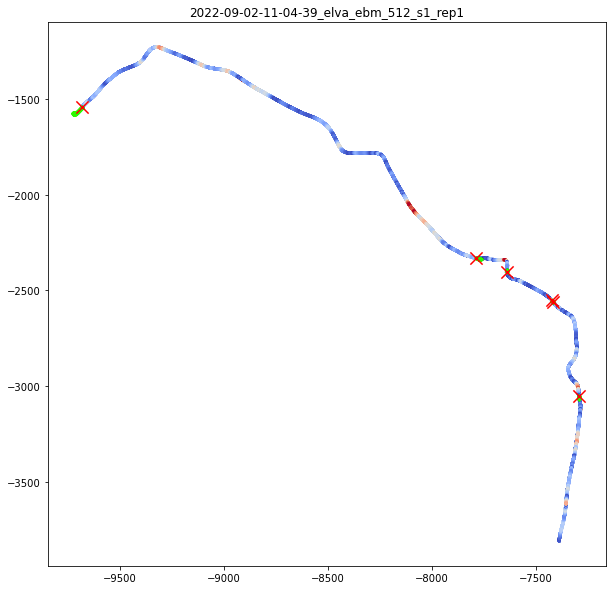

In [22]:
model_driven_ds = NvidiaDataset([root_path / '2022-09-02-11-04-39_elva_ebm_512_s1_rep1'])
print(calculate_closed_loop_metrics(model_driven_ds.frames, expert_ds.frames, model_driven_ds.vehicle_cmd_frames))
draw_error_plot(model_driven_ds, expert_ds, "2022-09-02-11-04-39_elva_ebm_512_s1_rep1")

In [10]:
datasets = {
        'autumn-v3': NvidiaDataset([root_path / '2021-11-03-12-35-19_e2e_rec_elva_autumn-v3']),
        'wide-v2': NvidiaDataset([root_path / '2021-11-03-13-13-16_e2e_rec_elva_wide-v2']),
        'autumn-v1': NvidiaDataset([root_path / '2021-11-03-13-51-53_e2e_rec_elva_autumn-v1', 
                                root_path / '2021-11-03-14-02-07_e2e_rec_elva_autumn-v1_continue']),
        'autumn-v3-overfit': NvidiaDataset([root_path / '2021-11-03-14-31-14_e2e_rec_elva_autumn-v3-last']),
        'autumn-v3-drive-2': NvidiaDataset([root_path / '2021-11-03-15-07-12_e2e_rec_elva_autumn-v3-drive2'])
}

/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-12-35-19_e2e_rec_elva_autumn-v3: 30068
/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-13-13-16_e2e_rec_elva_wide-v2: 29327
/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-13-51-53_e2e_rec_elva_autumn-v1: 15142
/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-14-02-07_e2e_rec_elva_autumn-v1_continue: 15153
/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-14-31-14_e2e_rec_elva_autumn-v3-last: 29630
/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-15-07-12_e2e_rec_elva_autumn-v3-drive2: 29729


In [15]:
metrics = calculate_metrics(datasets, expert_ds)
metrics

Calculating metrics for autumn-v3
Calculating metrics for wide-v2
Calculating metrics for autumn-v1
Calculating metrics for autumn-v3-overfit
Calculating metrics for autumn-v3-drive-2


model       mae      rmse       max  failure_rate  \
0          autumn-v3  0.502230  0.622957  1.714611     12.241000   
1            wide-v2  0.443960  0.588631  1.726209     11.112764   
2          autumn-v1  0.552140  0.684312  1.719333     17.456469   
3  autumn-v3-overfit  0.451016  0.586969  1.717028     10.650157   
4  autumn-v3-drive-2  0.450061  0.562311  1.721292      7.595274   

  interventions  whiteness  expert_whiteness  
0            19  40.575212         22.535896  
1            19  31.612728         22.535896  
2            39  27.345045         22.535896  
3            30  35.151487         22.535896  
4            31  37.789747         22.535896

In [ ]:
# intervention_adjustments = {
#     'autumn-v3': 0, 
#     'wide-v2': 0,
#     'autumn-v1': 0,
#     'autumn-v3-overfit': 0,
#     'autumn-v3-drive-2': 0,
# }

# for name, adj in intervention_adjustments.items():
#     metrics[metrics.model == name] = metrics[metrics.model == name].interventions - adj

In [16]:
datasets_backwards = {
    'autumn-v3': NvidiaDataset([root_path / '2021-11-03-12-53-38_e2e_rec_elva_back_autumn-v3']),
    'wide-v2': NvidiaDataset([root_path / '2021-11-03-13-30-48_e2e_rec_elva_back_wide-v2']),
    'autumn-v1': NvidiaDataset([root_path / '2021-11-03-14-12-10_e2e_rec_elva_back_autumn-v1']),
    'autumn-v3-overfit': NvidiaDataset([root_path / '2021-11-03-14-48-21_e2e_rec_elva_back_autumn-v3-last']),
    'autumn-v3-drive-2': NvidiaDataset([root_path / '2021-11-03-15-25-36_e2e_rec_elva_back_autumn-v3-drive2'])
}

/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-12-53-38_e2e_rec_elva_back_autumn-v3: 30471
/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-13-30-48_e2e_rec_elva_back_wide-v2: 30505
/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-14-12-10_e2e_rec_elva_back_autumn-v1: 30376
/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-14-48-21_e2e_rec_elva_back_autumn-v3-last: 30747
/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-15-25-36_e2e_rec_elva_back_autumn-v3-drive2: 30382


In [17]:
metrics_backwards = calculate_metrics(datasets_backwards, expert_back_ds)
metrics_backwards

Calculating metrics for autumn-v3
Calculating metrics for wide-v2
Calculating metrics for autumn-v1
Calculating metrics for autumn-v3-overfit
Calculating metrics for autumn-v3-drive-2


model       mae      rmse       max  failure_rate  \
0          autumn-v3  0.516410  0.650548  1.721210     11.159653   
1            wide-v2  0.476433  0.619278  1.719881     10.728426   
2          autumn-v1  0.551390  0.677234  1.718249     12.491294   
3  autumn-v3-overfit  0.500938  0.620764  1.715706     11.452504   
4  autumn-v3-drive-2  0.444941  0.556454  1.720779      7.264722   

  interventions  whiteness  expert_whiteness  
0            13  27.871334         24.159325  
1            13  29.357156         24.159325  
2            11  26.772094         24.159325  
3            23  34.136939         24.159325  
4            23  32.510528         24.159325

0 autumn-v3
1 wide-v2
2 autumn-v1
3 autumn-v3-overfit
4 autumn-v3-drive-2
0 autumn-v3
1 wide-v2
2 autumn-v1
3 autumn-v3-overfit
4 autumn-v3-drive-2


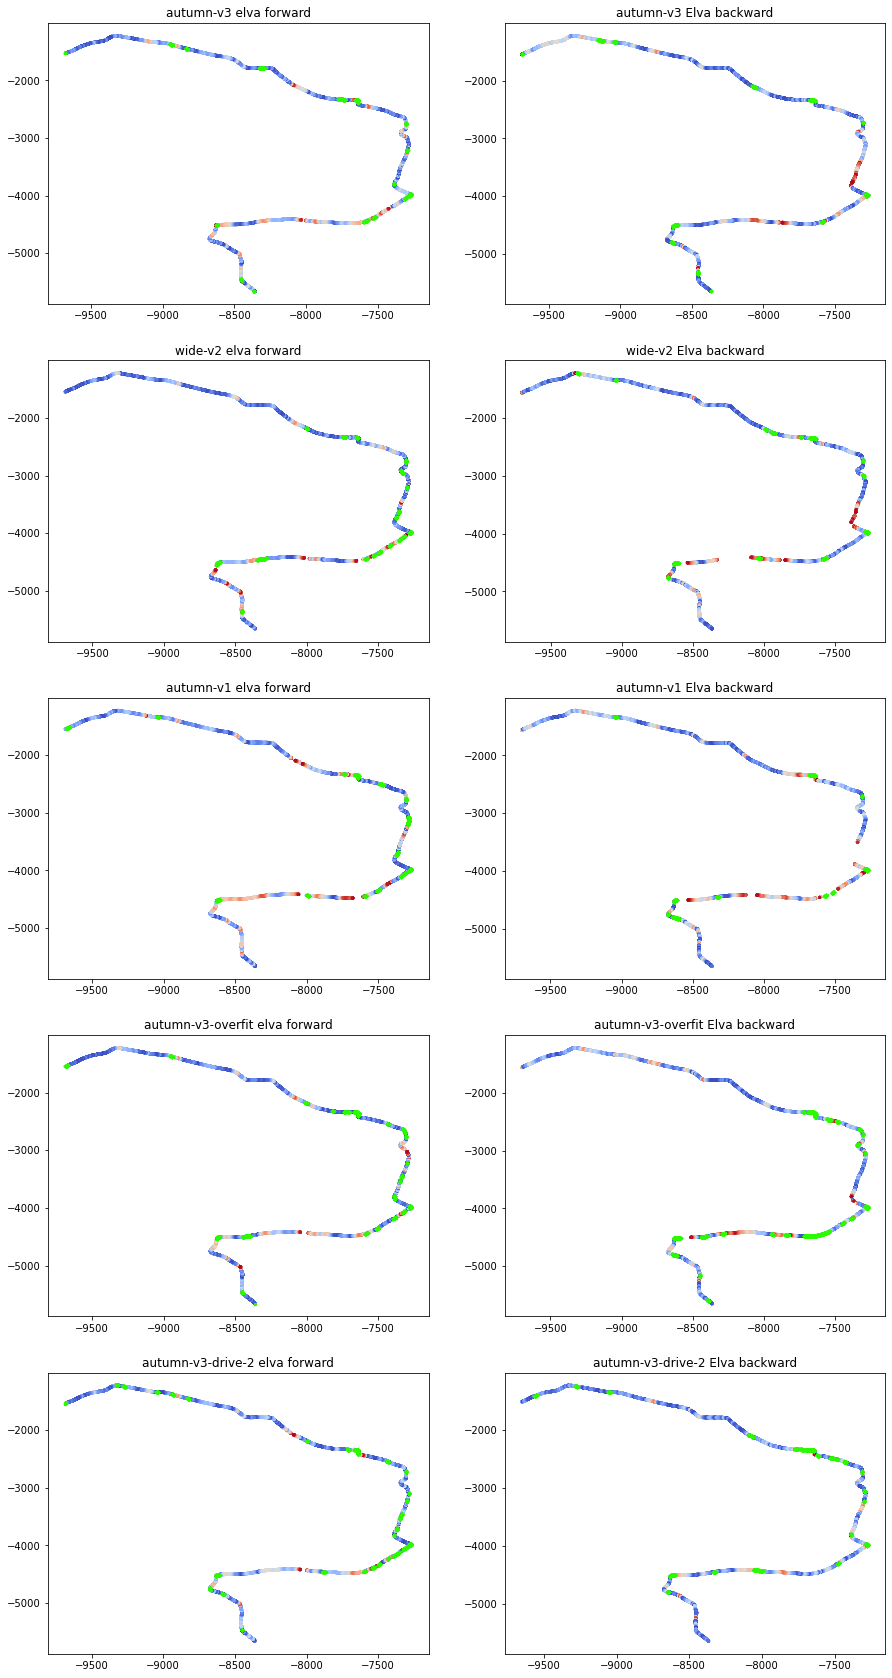

In [19]:
fig, ax = plt.subplots(5, 2, figsize=(15, 30))

for i, (name, ds) in enumerate(datasets.items()): 
    print(i, name)
    draw_error_plot_ax(ax[i][0], ds, expert_ds, f"{name} elva forward")
    
for i, (name, ds) in enumerate(datasets_backwards.items()): 
    print(i, name)
    draw_error_plot_ax(ax[i][1], ds, expert_back_ds, f"{name} Elva backward")

In [20]:
fig.savefig("elva-2021-11-03.png", facecolor="white")